<a href="https://colab.research.google.com/github/kathechu/GEOG485/blob/main/Final_Project_Chu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality and Superfund Sites in Los Angeles, California

[Superfund sites](https://www.epa.gov/superfund/what-superfund) are abandoned contaminated lands designated by the Environmental Protection Agency (EPA). These sites are targetted by the EPA to force a clean up of the area, either by those responsible or by the EPA itself, after being reimbursed by those in charge of the site.

As of March 7th, 2024, there are a total of 1,340 sites across the U.S.

Since Superfund sites are sites of pollution I was curious to know if there would be a significant change in air quality near these sites. For the sake of the project, only nitrogen dioxide (NO2) emissions will be examined.

**Research Question:** Is there a relationship between NO2 emissions and the location of superfund sites?


## Read in Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/GEOG485/Data/final/')

In [ ]:
!pip install colour
!pip install h3
!pip install rtree
!pip install geopandas
!pip install rioxarray
!pip install contextily #basemap library
!pip install -U mapclassify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 54.9 MB/s eta 0:00:00


In [ ]:
import h3
from shapely.geometry import Polygon, Point
import shapely.wkt
import folium

import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

from scipy.interpolate import griddata

import warnings
warnings.filterwarnings("ignore")

# H3 Clustering of Superfund Sites in California


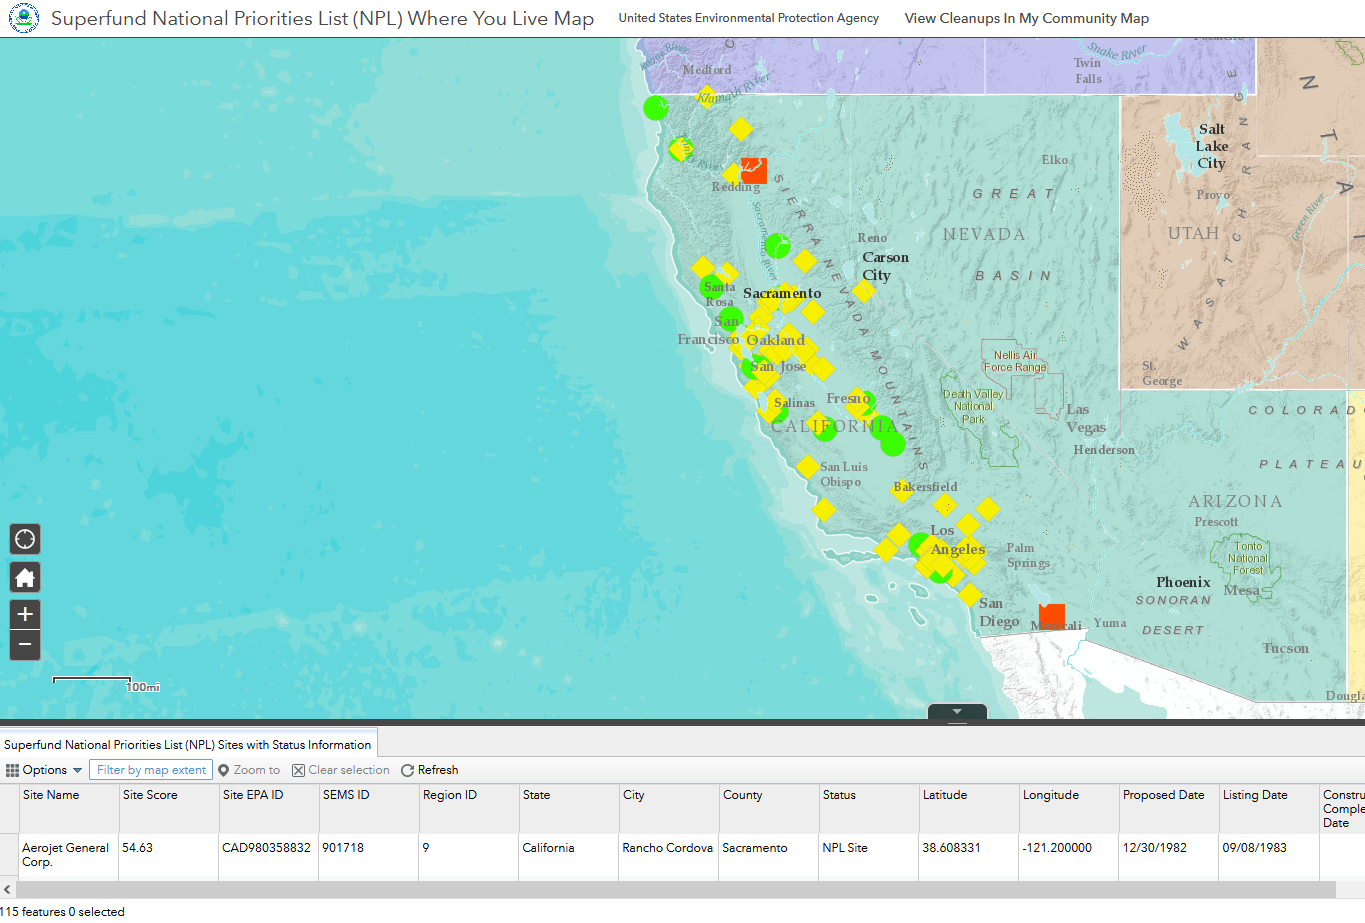

The [Superfund site data](https://epa.maps.arcgis.com/apps/webappviewer/index.html?id=33cebcdfdd1b4c3a8b51d416956c41f1&query=Superfund_National_Priorities_List__NPL__Sites_with_Status_Information_7557,SITE_EPA_ID=%27ALD004022448%27) was taken from the EPA's ArcGIS map dedicated to recording all Superfund sites, current and cleaned. The data was filtered to within California before being processed here.

*Uber's Hexagonal Hierarchical Spatial Index (H3)* utilizes hexagons that cover a projection of the Earth. Any location can be found within a hexagon and there are various levels of resolution that can be used for H3. H3 clustering is a helpful way to visualize the number of points in a given area, which is what we'll use for the Superfund site data.


## Read in Data

In [ ]:
superfund = pd.read_csv('Superfund National Priorities List (NPL) Sites with Status Information(1).csv')

In [ ]:
superfund.head()

Site Name  Site Score   Site EPA ID  SEMS ID  Region ID  \
0  Aerojet General Corp.       54.63  CAD980358832   901718          9   
1  Celtor Chemical Works       30.31  CAD980638860   901938          9   
2  Coast Wood Preserving       44.73  CAD063015887   901489          9   
3     Iron Mountain Mine       56.16  CAD980498612   901755          9   
4       Jibboom Junkyard       28.94  CAD980737613   902040          9   

        State            City      County            Status   Latitude  ...  \
0  California  Rancho Cordova  Sacramento          NPL Site  38.608331  ...   
1  California           Hoopa    Humboldt  Deleted NPL Site  41.102700  ...   
2  California           Ukiah   Mendocino          NPL Site  39.112500  ...   
3  California         Redding      Shasta          NPL Site  40.671669  ...   
4  California      Sacramento  Sacramento  Deleted NPL Site  38.591669  ...   

                              Site Listing Narrative  \
0  <a href="https://semspub.epa.gov/src/document/...   
1  <a href="https://semspub.epa.gov/src/document/...   
2  <a href="https://semspub.epa.gov/src/document/...   
3  <a href="https://semspub.epa.gov/src/document/...   
4  <a href="https://semspub.epa.gov/src/document/...   

                               Site Progress Profile  \
0  <a href="https://cumulis.epa.gov/supercpad/cur...   
1  <a href="https://cumulis.epa.gov/supercpad/cur...   
2  <a href="https://cumulis.epa.gov/supercpad/cur...   
3  <a href="https://cumulis.epa.gov/supercpad/cur...   
4  <a href="https://cumulis.epa.gov/supercpad/cur...   

                                  Proposed FR Notice  \
0  <a href="https://semspub.epa.gov/src/document/...   
1  <a href="https://semspub.epa.gov/src/document/...   
2  <a href="https://semspub.epa.gov/src/document/...   
3  <a href="https://semspub.epa.gov/src/document/...   
4  <a href="https://semspub.epa.gov/src/document/...   

                                   Listing FR Notice  \
0  <a href="https://semspub.epa.gov/src/document/...   
1  <a href="https://semspub.epa.gov/src/document/...   
2  <a href="https://semspub.epa.gov/src/document/...   
3  <a href="https://semspub.epa.gov/src/document/...   
4  <a href="https://semspub.epa.gov/src/document/...   

                                      NOID FR Notice  \
0                                                NaN   
1  <a href="http://www.gpo.gov/fdsys/pkg/FR-2003-...   
2                                                NaN   
3                                                NaN   
4  <a href="https://semspub.epa.gov/src/document/...   

                                  Deletion FR Notice  \
0                                                NaN   
1  <a href="http://www.gpo.gov/fdsys/pkg/FR-2003-...   
2                                                NaN   
3                                                NaN   
4  <a href="https://semspub.epa.gov/src/document/...   

  Restoration FR Notice Jumper Page Site has had a Partial Deletion  \
0                               NaN                              No   
1                               NaN                              No   
2                               NaN                              No   
3                               NaN                              No   
4                               NaN                              No   

              x             y  
0 -1.349192e+07  4.665723e+06  
1 -1.376923e+07  5.027502e+06  
2 -1.371378e+07  4.737799e+06  
3 -1.363973e+07  4.964033e+06  
4 -1.352569e+07  4.663349e+06  

[5 rows x 27 columns]

Clean up the data so that the following columns are kept: 'Site Name', 'Site Score', 'City', 'County', 'Status', 'Latitude', and 'Longitude'.

In [ ]:
sf = superfund[['Site Name', 'Site Score','City','County','Status', 'Latitude', 'Longitude']]

Check the data.

In [ ]:
sf.head()

Site Name  Site Score            City      County  \
0  Aerojet General Corp.       54.63  Rancho Cordova  Sacramento   
1  Celtor Chemical Works       30.31           Hoopa    Humboldt   
2  Coast Wood Preserving       44.73           Ukiah   Mendocino   
3     Iron Mountain Mine       56.16         Redding      Shasta   
4       Jibboom Junkyard       28.94      Sacramento  Sacramento   

             Status   Latitude  Longitude  
0          NPL Site  38.608331  -121.2000  
1  Deleted NPL Site  41.102700  -123.6911  
2          NPL Site  39.112500  -123.1930  
3          NPL Site  40.671669  -122.5278  
4  Deleted NPL Site  38.591669  -121.5033

## Superfund Site Status

Visualizing the status of Superfund sites in California would give us a better idea of how many sites are considered on the [National Priority List (NPL)](https://www.federalregister.gov/documents/2024/03/07/2024-04781/national-priorities-list). Under the Comprehensive Environmental Response, Compensation, and Liability Act of 1980 (CERCLA), NPL was made to identify all locations that are known to release or threaten to release hazardous substances. There are a few ways sites are placed on the NPL:


*   Scores high on the Hazard Ranking System (HRS), a metric from 0-100 that rates how threatening the site is on human and environmental health. Any site scoring above 28.5 is eligible for NPL.
*   States can also choose *one* site to be listed as an NPL, regardless of its HRS score if they deem it as a great danger.



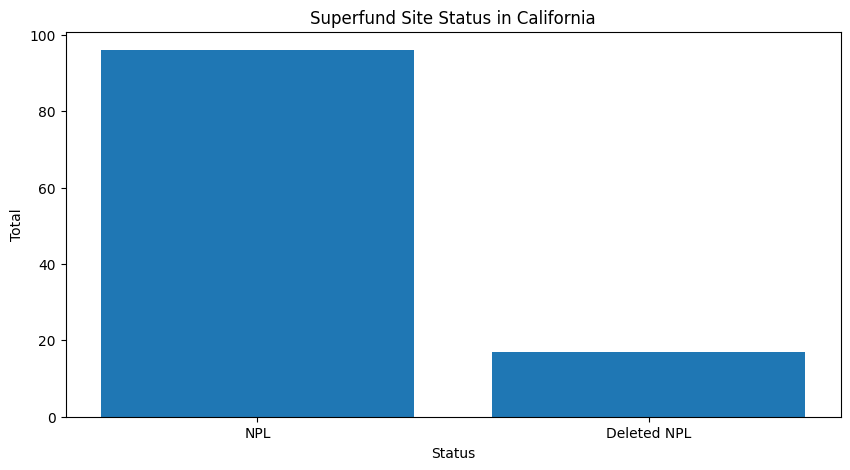

In [ ]:
# Count how many are currently and no longer NPL sites
npl = sf['Status'].value_counts()['NPL Site']
deleted = sf['Status'].value_counts()['Deleted NPL Site']

name = ['NPL', 'Deleted NPL']
value = [npl, deleted]

fig = plt.figure(figsize = (10, 5))
plt.bar(name, value)
plt.xlabel("Status")
plt.ylabel("Total")
plt.title("Superfund Site Status in California")
plt.show()

The bar chart shows that there is currently an overwhelming larger amount of active NPL sites compared to deleted NPL sites in California.

## H3 Clustering

To create an H3 cluster of Superfund sites in California, a few functions are needed. The **'lat_lng_to_h3'** function takes the coordinates of the site and converts it to the H3 id of the hexagon at the same location.

In [ ]:
def lat_lng_to_h3(row, h3_level):
    '''
    The function lat_lng_to_h3 converts a location's coordinates into an H3 id of the chosen level.
    '''
    return h3.geo_to_h3(row.Latitude, row.Longitude, h3_level)

def add_geometry(row):
    '''
    To visualize the results or export it to a GIS, we need to convert the H3 cell ids
    to a geometry. The h3_to_geo_boundary function takes a H3 key and returns
    a list of coordinates that form the hexagonal cell. Since GeoPandas uses
    shapely library for constructing geometries, we convert the list of coordinates
    to a shapely Polygon object. Note the optional second argument to the
    h3_to_geo_boundary function which we have set to True which returns the coordinates
    in the (x,y) order compared to default (lat,lon)
    '''
    points = h3.h3_to_geo_boundary(row['h3_id'], True)
    return Polygon(points)

In [ ]:
def generate_counts_gdf(h3_level):
    h3_level = h3_level

    # Convert a location's coordinates into an H3 id of the chosen level
    sf['h3_id'] = sf.apply(lat_lng_to_h3, h3_level=h3_level, axis=1)

    # Use Panda's groupby function on the h3_id column and add a new column count to the output with the number of rows for each H3 id.
    counts = sf.groupby(['h3_id']).h3_id.agg('count').to_frame('count').reset_index()

    # Add 'geometry' column for each h3_id
    counts['geometry'] = counts.apply(add_geometry, axis=1)

    # Convert the dataframe to a GeoDataframe with the CRS EPSG:4326
    counts_gdf = gpd.GeoDataFrame(counts, crs='EPSG:4326')

    return counts_gdf

72 hexagons


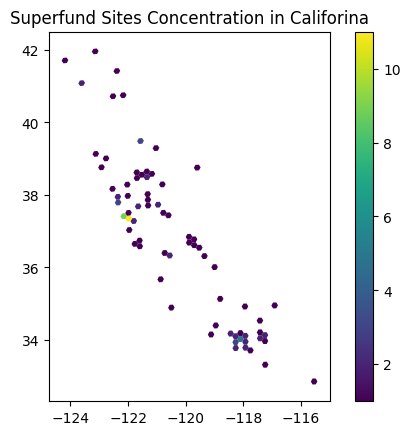

In [ ]:
counts_gdf = generate_counts_gdf(5)
counts_gdf.plot(column='count', legend=True)
plt.title('Superfund Sites Concentration in Califorina')

print(counts_gdf.shape[0],'hexagons')

In [ ]:
counts_gdf = counts_gdf.set_crs('epsg:4326')

In [ ]:
# Create a Map instance

m = folium.Map(location=[36.773,-119.5945], tiles = 'cartodbpositron',
               zoom_start=7, control_scale=True)

# Create 'geoid' column based on the index value of counts and
# make sure it is in string dtype, replace None
counts_gdf['geoid'] = counts_gdf.index.astype(str)

# Create a choropleth map using the counts gdf
folium.Choropleth(geo_data = counts_gdf,
                  data = counts_gdf,
                  columns=['geoid','count'],
                  key_on='feature.id',
                  fill_color='YlOrRd',
                  line_color='white',
                  line_weight=0,
                  legend_name= 'Site count in hexagon').add_to(m)

# Create a pop-up tooltip to enhance the interactivity,
folium.features.GeoJson(counts_gdf,
                        name='Labels',
                        style_function=lambda x: {'color':'transparent',
                                                  'fillColor':'transparent',
                                                  'weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['count'],
                                             aliases = ['Site count in hexagon'],
                                             labels=True,
                                             sticky=True)
                       ).add_to(m)

#Show map
m

There is a higher concentration of Superfund sites located in San Jose and Los Angeles. Let's take a closer look at the specific sites in LA.

In [ ]:
la = sf.loc[sf['County'].isin(['Los Angeles'])].reset_index()

In [ ]:
la.head()

index                             Site Name  Site Score               City  \
0     18           San Gabriel Valley (Area 1)       42.24           El Monte   
1     19           San Gabriel Valley (Area 2)       42.24  Baldwin Park Area   
2     20           San Gabriel Valley (Area 3)       28.90           Alhambra   
3     21           San Gabriel Valley (Area 4)       28.90          La Puente   
4     23  Operating Industries, Inc., Landfill       57.22      Monterey Park   

        County    Status   Latitude   Longitude            h3_id  
0  Los Angeles  NPL Site  34.125000 -118.000000  8529a1dbfffffff  
1  Los Angeles  NPL Site  34.073611 -117.936100  8529a1dbfffffff  
2  Los Angeles  NPL Site  34.100000 -118.125000  8529a1d3fffffff  
3  Los Angeles  NPL Site  34.016669 -117.958300  8529a0a7fffffff  
4  Los Angeles  NPL Site  34.033333 -118.105556  8529a1d3fffffff

In [ ]:
la_gdf = gpd.GeoDataFrame(
    la, geometry= gpd.points_from_xy(la.Longitude, la.Latitude), crs="EPSG:4326"
)

Folium is a helpful interactive mapping library that allows us to view Superfund site clusters in LA.

In [ ]:
from folium.plugins import MarkerCluster

# Create a Map instance
m = folium.Map(location=[34.0549,-118.2426],
    zoom_start=10, control_scale=True)

# Create a folium marker cluster and add marker cluster to map, replace None
marker_cluster = MarkerCluster().add_to(m)

# Add marker through interation, replace None
for i in range(la_gdf.shape[0]):
    folium.CircleMarker(
        location=[la_gdf.loc[i,'Latitude'], la_gdf.loc[i,'Longitude']],
        radius=5,
    ).add_to(marker_cluster) #don't directly add to the map instance, but instead to the marker cluster

#Show map
m

From the map we can see that there are 18 Superfund sites within LA county, with four concentrated at South Gate.



## Los Angeles Superfund Site Scores

Under the Superfund program, the EPA and state agencies use the Hazard Ranking System (HRS) to calculate a site score (ranging from 0 to 100) based on the actual or potential release of hazardous substances from a site through air, surface water or groundwater.

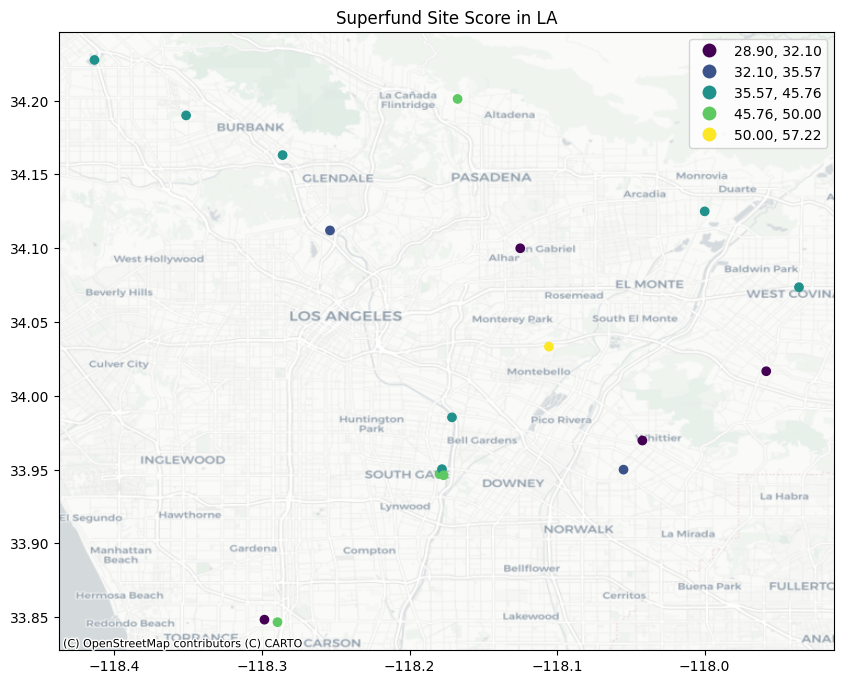

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10,10))

la_gdf.plot(column='Site Score', scheme='NaturalBreaks', ax=ax, legend=True)

plt.title("Superfund Site Score in LA")

# Add basemap
cx.add_basemap(ax, crs=la_gdf.crs, source=cx.providers.CartoDB.Positron)

From this map, we see the highest ranking site is at 57.22 by Montebello. Other sites with higher ratings (45.76 - 50.00) can be seen by South Gate, Lan Cañada Flintridge, and Carson.

# TEMPO Air Quality Data and Superfund Sites

Using the TEMPO data, we can look into if there are consistent concentrations of NO2 emissions near Superfund sites. TEMPO is a satellite that tracks air pollutants across North America. The satellite collects hourly measurements of a variety of pollutants, including ozone, carbon dioxide, and nitrogen dioxide. For the purpose of this project, we'll only focus on nitrogen dioxide.

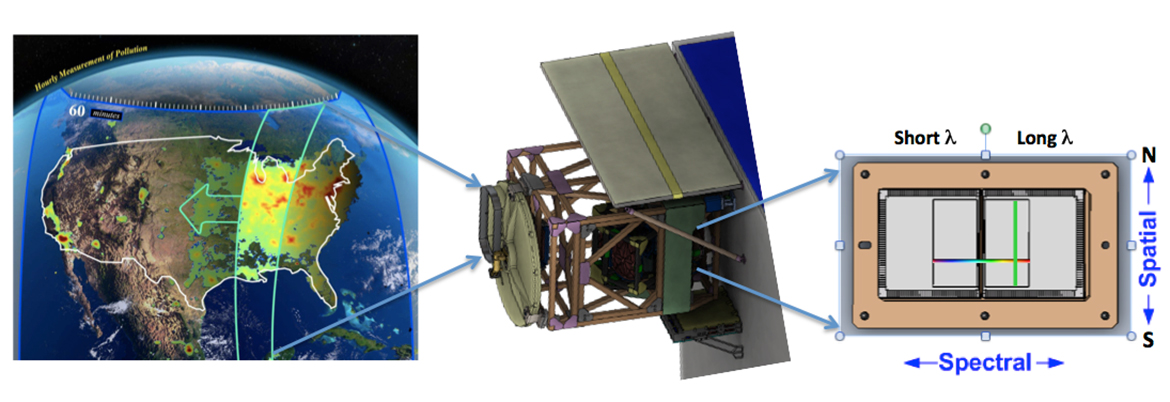

### Read in Boundary Data

Using the county boundaries makes it easier for us to track where the Superfund sites and NO2 emissions are located.

In [ ]:
ca_county = gpd.read_file('ca_county_boundaries/ca_county_boundaries.shp', bbox=(-118.7, 33.6, -117.0, 34.6))
ca_places = gpd.read_file('ca_places_boundaries/ca_places_boundaries.shp', bbox=(-118.7, 33.6, -117.0, 34.6))
LA = ca_places.loc[ca_places['NAME'] == 'Los Angeles']

In [ ]:
# Iterate over all 10 files and generate the regridded no2 data
files = ['tempo_no2/'+f for f in os.listdir('tempo_no2/')]

# Make sure your list is sorted
files.sort()

## Read in TEMPO Raster Data


In [ ]:
# Use a for loop to iterate over all 10 files and generate the regridded no2 data

# Initiate an empty list that stores the no2_grids for each file
no2_grids_list = []
obs_time_list = []

# Set the region: -118.7, -117.5, 33.6, 34.5
minlon, maxlon, minlat, maxlat = -118.7, -117.5, 33.6, 34.5

# Prepare a new grid line with 0.05 degree resolution
xnew = np.arange(minlon,maxlon+0.05,0.05)
ynew = np.arange(minlat,maxlat+0.05,0.05)

# Create 2D matrix for longitude and latitude
xxnew, yynew = np.meshgrid(xnew,ynew)

for f in files:
    # Read dataset
    ds = rxr.open_rasterio(f)

    # set crs
    data = ds[0].rio.write_crs(4326)

    # Get the observation time
    obs_time = data.time_coverage_start

    # Convert the observation time to np.datetime64
    obs_time = np.datetime64(obs_time)

    # append to obs_time_list
    obs_time_list.append(obs_time)

    # Extract longitude and latitude
    lon = data['longitude'].rio.interpolate_na()[0,:,:]
    lat = data['latitude'].rio.interpolate_na()[0,:,:]

    # Fill the _FillValue attribute with np.nan: code provided
    data['vertical_column_troposphere'] = data['vertical_column_troposphere'].where(data['vertical_column_troposphere'] != data['vertical_column_troposphere']._FillValue, np.nan)

    # Select so that the dataarray is 2D
    no2_converted = data.vertical_column_troposphere[0,:,:]

    # Fill the negative values with 0 (try where() function)
    no2_converted = np.nan_to_num(no2_converted)

    # no2_converted = np.where(no2_converted < 0, 0, no2_converted)

    # Flatten the lon, lat, and no2_converted
    lons_flatten, lats_flatten, no2_flatten = lon.data.flatten(), lat.data.flatten(), no2_converted.flatten()

    # Compose a numpy array of x and y values
    points = np.array([lons_flatten,lats_flatten])

    points = points.T

    # Conduct griddata from scipy.interpolate using nearest value
    no2_grids = griddata(points, no2_flatten, (xxnew, yynew), method = 'nearest')

    # Append to no2_grids_list
    no2_grids_list.append(no2_grids)

In [ ]:
# Concatenate the 10 numpy arrays in co_grids_list into a 3D array (hint: np.stack()). should be around (30, 19, 26)
no2_grids_3d = np.stack(no2_grids_list)

no2_grids_3d.shape

(30, 19, 25)

In [ ]:
# Create a xarray dataset based on the collected 10 days' data

ds_tempo =  xr.Dataset(
    data_vars=dict(
        no2_grid=(["time", "lat", "lon"], no2_grids_3d),
    ),
    coords=dict(
        lat=ynew,
        lon=xnew,
        time=obs_time_list,
    ),
)


## Create Superfund Site Buffer
To easily visualize any potential pattern with Superfund sites and NO2 emission concentrations, a buffer around sites would be beneficial to generate.

In [ ]:
from shapely.ops import unary_union

merge = unary_union(la_gdf['geometry'])
buffer = merge.buffer(0.05)

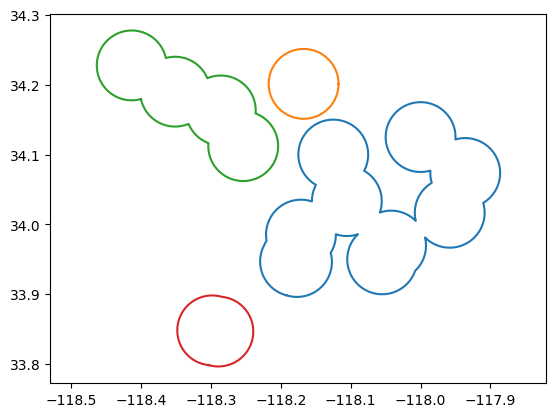

In [ ]:
for geom in buffer.geoms:
    plt.plot(*geom.exterior.xy)

# Set (current) axis to be equal before showing plot
plt.gca().axis("equal")
plt.show()

## Plot Air Quality and Superfund Sites

With all of the necessary data loaded, we can overlay each and interpret if there is any significant connection between NO2 emissions and the location of Superfund sites.

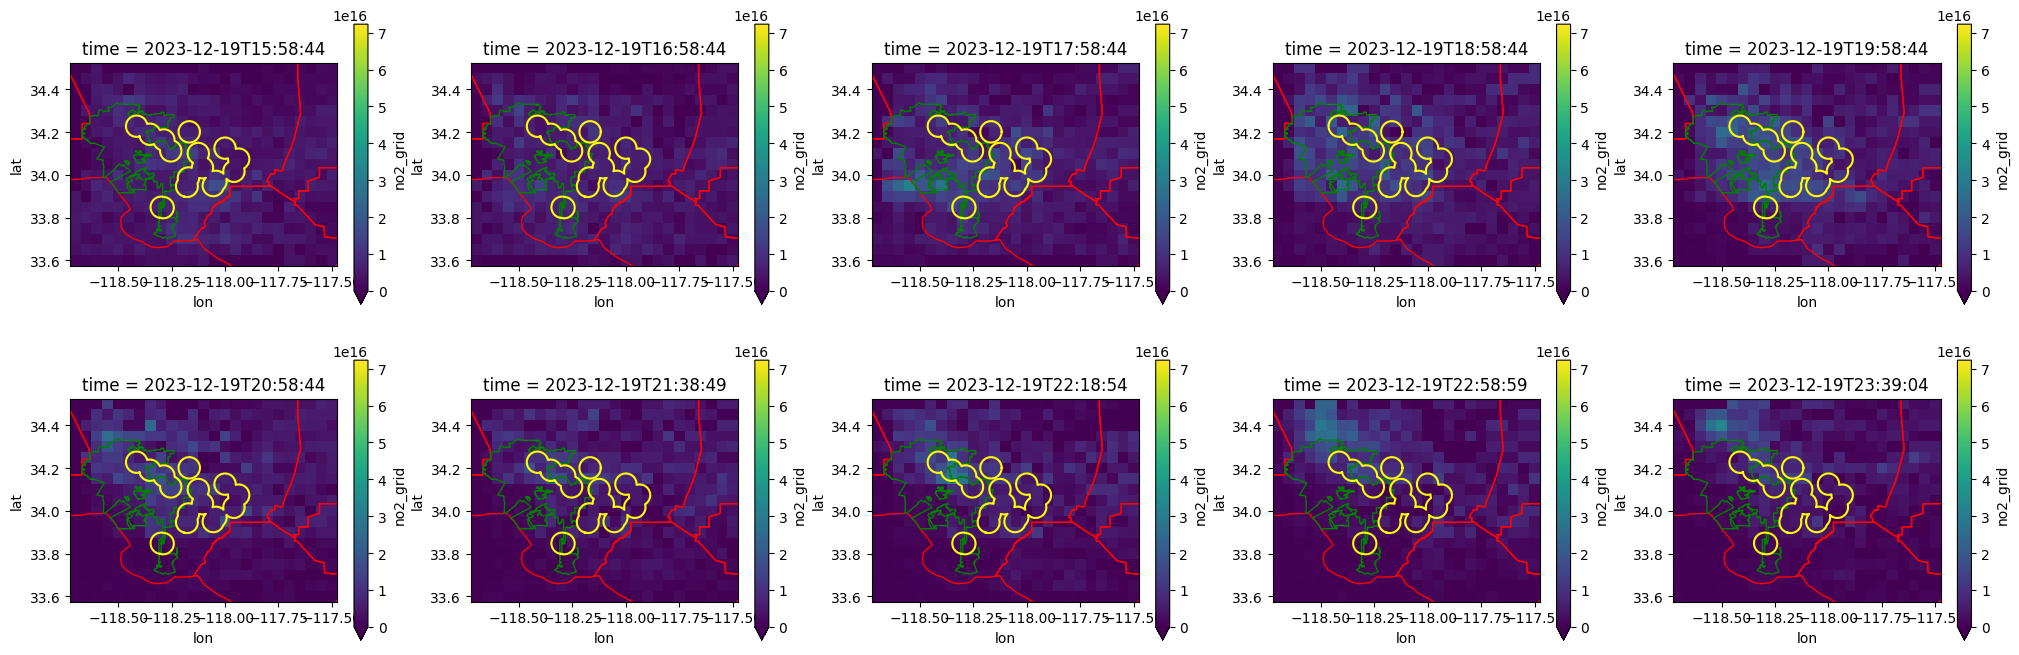

In [ ]:
# Plot the first day from TEMPO's observation: 2 rows and 5 columns

fig, ax = plt.subplots(2, 5, figsize=(25, 8))

idx = 0

for i in range(2):
    for j in range(5):

        # use positional index to select day
        ds_tempo['no2_grid'].isel(time=idx).plot(ax=ax[i,j],
                                          vmin=0,
                                          vmax=float(ds_tempo['no2_grid'].max().values))
        # Set aspect equal for subplots
        ax[i,j].axes.set_aspect('equal')

        # plot boundaries
        ca_county.plot(ax=ax[i,j], facecolor="none", edgecolor='red')
        LA.plot(ax=ax[i,j], facecolor="none", edgecolor='green')

        # plot superfund buffer
        for geom in buffer.geoms:
            ax[i,j].plot(*geom.exterior.xy, color="yellow")

        # move to the next time point
        idx += 1

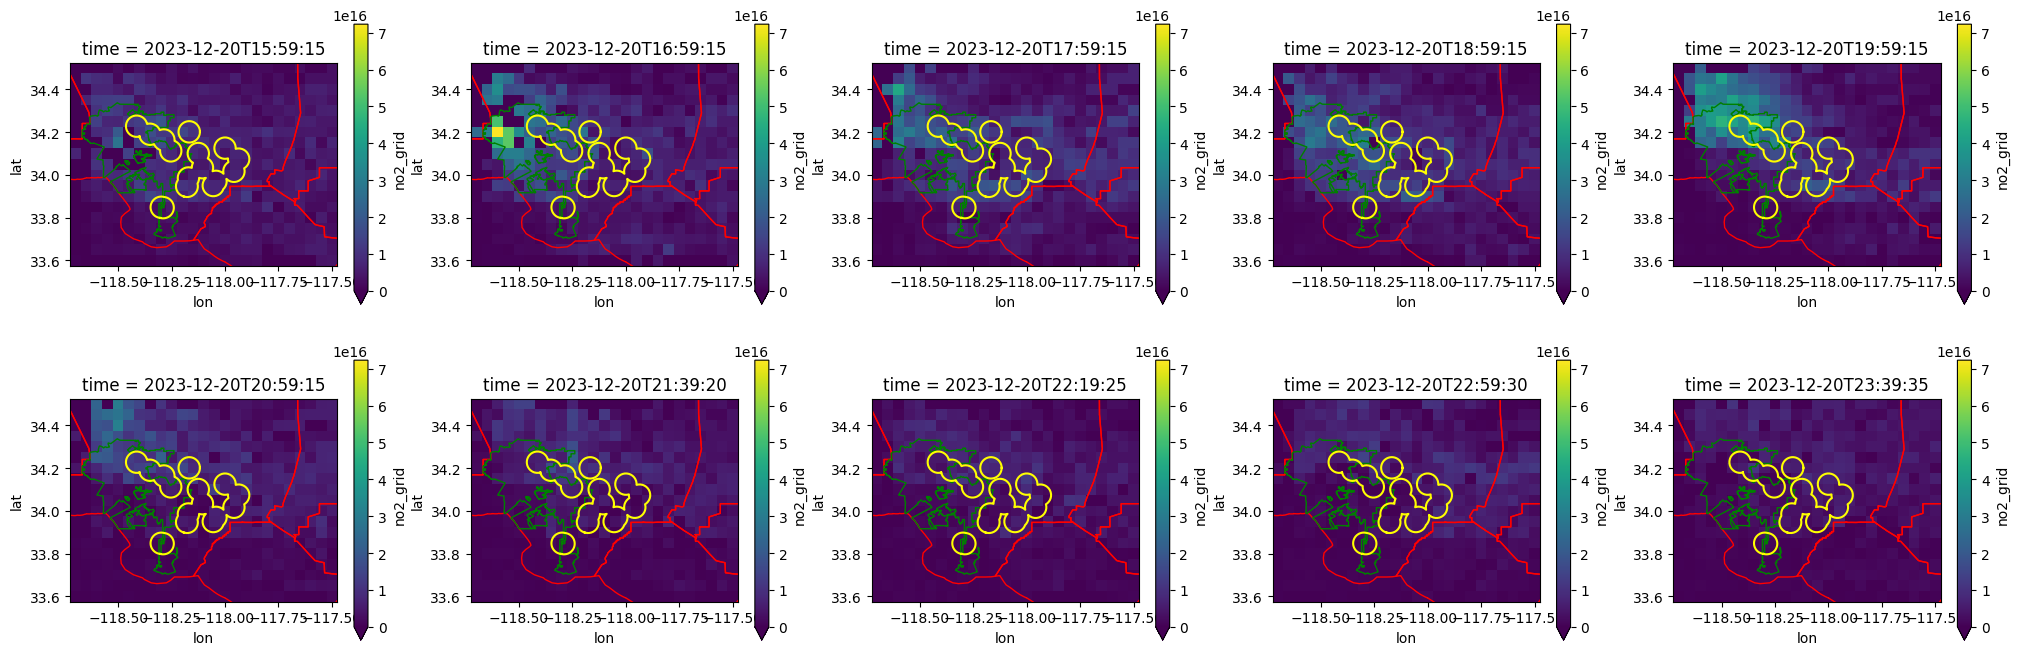

In [ ]:
# Plot the SECOND day from TEMPO's observation: 2 rows and 5 columns

fig, ax = plt.subplots(2, 5, figsize=(25, 8))

idx = 10

for i in range(2):
    for j in range(5):

        # use positional index to select day
        ds_tempo['no2_grid'].isel(time=idx).plot(ax=ax[i,j],
                                          vmin=0,
                                          vmax=float(ds_tempo['no2_grid'].max().values))
        # Set aspect equal for subplots
        ax[i,j].axes.set_aspect('equal')

        # plot boundaries
        ca_county.plot(ax=ax[i,j], facecolor="none", edgecolor='red')
        LA.plot(ax=ax[i,j], facecolor="none", edgecolor='green')

        # plot superfund buffer
        for geom in buffer.geoms:
            ax[i,j].plot(*geom.exterior.xy, color="yellow")

        # move to the next time point
        idx += 1

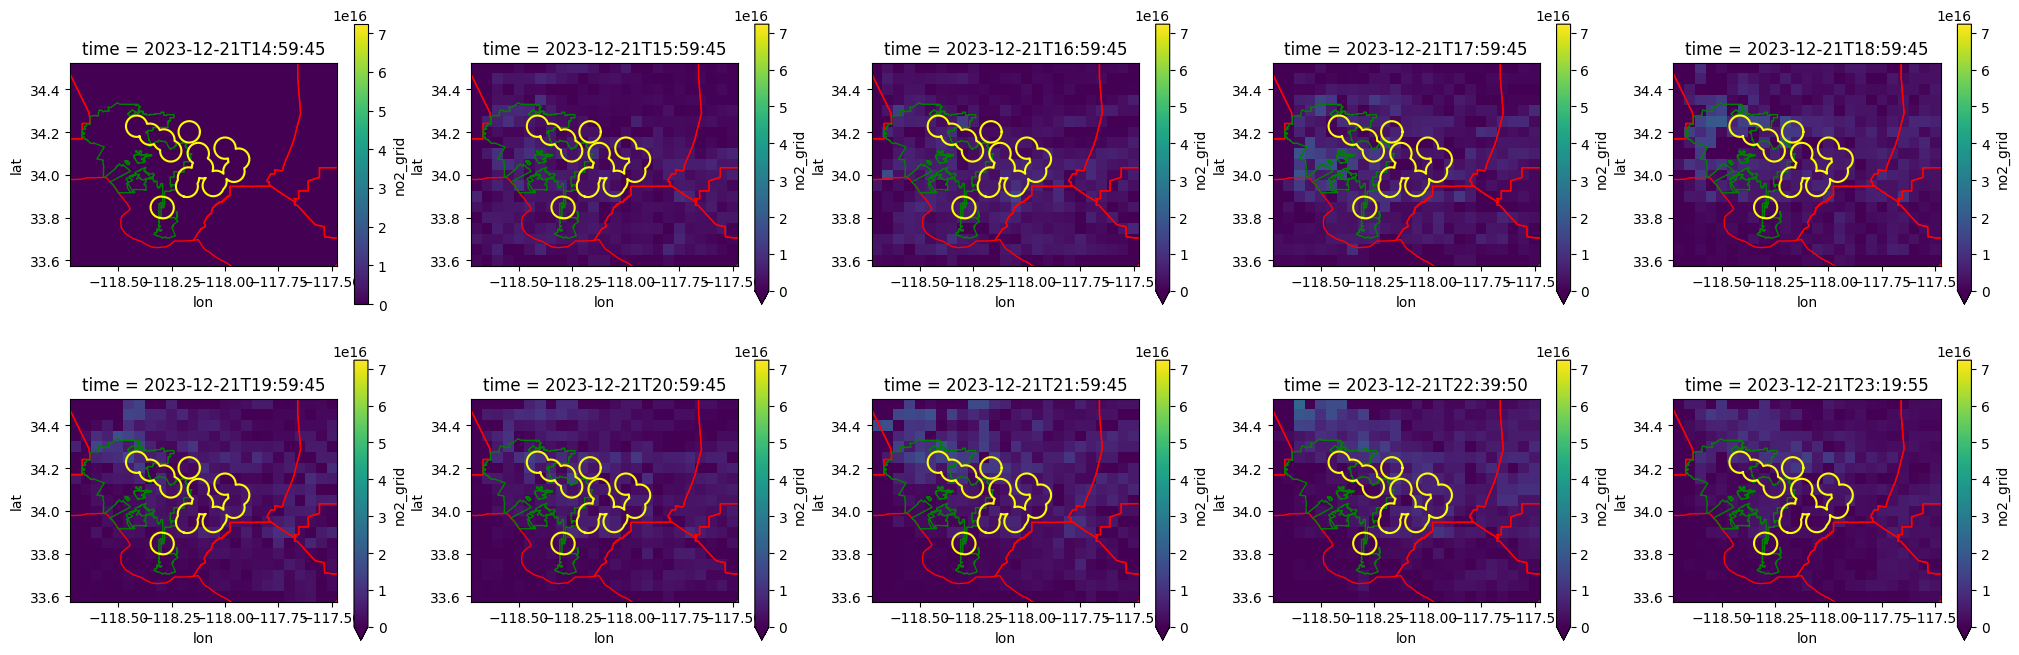

In [ ]:
# Plot the THIRD day from TEMPO's observation: 2 rows and 5 columns

fig, ax = plt.subplots(2, 5, figsize=(25, 8))

idx = 20

for i in range(2):
    for j in range(5):

        # use positional index to select day
        ds_tempo['no2_grid'].isel(time=idx).plot(ax=ax[i,j],
                                          vmin=0,
                                          vmax=float(ds_tempo['no2_grid'].max().values))
        # Set aspect equal for subplots
        ax[i,j].axes.set_aspect('equal')

        # plot boundaries
        ca_county.plot(ax=ax[i,j], facecolor="none", edgecolor='red')
        LA.plot(ax=ax[i,j], facecolor="none", edgecolor='green')

        # plot superfund buffer
        for geom in buffer.geoms:
            ax[i,j].plot(*geom.exterior.xy, color="yellow")

        # move to the next time point
        idx += 1

# Conclusion

Overall there is a consistent concentration along the Superfund site locations, but they are not significantly large emissions around the sites. There are other factors that may contribute to the higher emissions such as increased traffic. Therefore we cannot conclude that the emissions are directly caused by the sites.

Additionally, since characteristics of Superfund sites vary, some sites may release other air pollutants asides from NO2. NO2 emissions are primarily from the burning of fuel, such as from vehicles, power plants, and off road equipment. As these are the [main sources of NO2](https://www.epa.gov/no2-pollution/basic-information-about-no2), it is understandable if most Superfund sites emit another air pollutant that is not reflected in this project. Superfund sites may also have [a greater effect on the soil](https://www.epa.gov/superfund/contaminants-superfund-sites) rather than the air, with contaminants such as lead, asbestos, and radiation.
